<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Model-building" data-toc-modified-id="Model-building-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Model building</a></span><ul class="toc-item"><li><span><a href="#Model-with-estimate-lag-time" data-toc-modified-id="Model-with-estimate-lag-time-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>Model with estimate lag time</a></span></li><li><span><a href="#Model-with-exact-lag-time" data-toc-modified-id="Model-with-exact-lag-time-0.2.2"><span class="toc-item-num">0.2.2&nbsp;&nbsp;</span>Model with exact lag time</a></span></li><li><span><a href="#Kolmogorov-Smirnov-test-for-Normality-Assumption-on-Residuals" data-toc-modified-id="Kolmogorov-Smirnov-test-for-Normality-Assumption-on-Residuals-0.2.3"><span class="toc-item-num">0.2.3&nbsp;&nbsp;</span>Kolmogorov Smirnov test for Normality Assumption on Residuals</a></span></li></ul></li></ul></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Random Forest</a></span><ul class="toc-item"><li><span><a href="#Correlation-Matrix" data-toc-modified-id="Correlation-Matrix-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Correlation Matrix</a></span></li><li><span><a href="#Creating-Datasets" data-toc-modified-id="Creating-Datasets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Creating Datasets</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
import scipy
sns.set()


Bad key "text.kerning_factor" on line 4 in
/Users/dylanho/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
df = pd.read_csv('../../data/processed/20th_May_olist.csv' , dtype={'seller_zip_code_prefix': str, 'customer_zip_code_prefix': str})

## Data Preprocessing

In [3]:
def calculate_time_difference_in_hour(data, col1, col2, target_col):
    data[target_col] = ((pd.to_datetime(data[col1]) - 
                            pd.to_datetime(data[col2]))
                                .dt.total_seconds() / (60 * 60))

In [4]:
df.seasons = df.seasons.astype('category')
df.seasons = df.seasons.cat.codes

In [5]:
calculate_time_difference_in_hour(df, 'order_delivered_carrier_date', 'order_purchase_timestamp', 'actual_lag_time')
calculate_time_difference_in_hour(df, 'shipping_limit_date', 'order_purchase_timestamp', 'estimate_lag_time')

In [6]:
df['total_delivery_time_log'] = np.log(df['total_delivery_time'])

## Model building

### Model with estimate lag time

In [7]:
# Shuffle indicies of the dataset
np.random.seed(123)  
np.random.shuffle(df.index.values)

In [8]:
training_size = int(df.shape[0]*0.7)
training_idx = df.index.values[0:training_size]
df_training = df[df.index.isin(training_idx)]
df_testing = df[df.index.isin(training_idx)]

In [9]:
df_testing_Y = df_testing.total_delivery_time_log
df_testing_X = df_testing.drop(['order_id', 'total_delivery_time_log'], axis=1)

In [10]:
model2 = smf.ols(formula='total_delivery_time_log ~ \
                                        connection_between_cities + \
                                        estimate_lag_time + \
                                        seasons + \
                                        rdpc', data=df_training).fit()
summary = model2.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     total_delivery_time_log   R-squared:                       0.675
Model:                                 OLS   Adj. R-squared:                  0.674
Method:                      Least Squares   F-statistic:                     3774.
Date:                     Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                             10:15:33   Log-Likelihood:                -3356.8
No. Observations:                     7286   AIC:                             6724.
Df Residuals:                         7281   BIC:                             6758.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     6.6434      0.014    491.637      0.000       6.617       6.670
connection_between_cities    -0.0003   2.65e-06   -115.241      0.000      -0.000      -0.000
estimate_lag_time          6.967e-06   2.15e-06      3.245      0.001    2.76e-06    1.12e-05
seasons                      -0.1011      0.009    -10.819      0.000      -0.119      -0.083
rdpc                         -0.0001   9.99e-06    -10.178      0.000      -0.000   -8.21e-05
==============================================================================
Omnibus:                      745.266   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2962.949
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       5.989   Cond. No.                     1.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
testing_pred2 = model2.predict(df_testing_X)
r22 = 1 - (np.sum((df_testing_Y - testing_pred2) ** 2) / np.sum((df_testing_Y - np.mean(df_testing_Y)) ** 2))
mae_2 = np.sum(abs(df_testing_Y - testing_pred2)) / len(df_testing_Y)
print('R-squared for testing data = ', r22)
print('Mean Absolute Error for testing data = ', mae_2)

R-squared for testing data =  0.6746124004334477
Mean Absolute Error for testing data =  0.2584393621858022


### Model with exact lag time

In [12]:
model = smf.ols(formula='total_delivery_time_log ~ \
                                        connection_between_cities + \
                                        actual_lag_time + \
                                        seasons + \
                                        rdpc', data=df_training).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     total_delivery_time_log   R-squared:                       0.711
Model:                                 OLS   Adj. R-squared:                  0.711
Method:                      Least Squares   F-statistic:                     4476.
Date:                     Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                             10:15:33   Log-Likelihood:                -2926.1
No. Observations:                     7286   AIC:                             5862.
Df Residuals:                         7281   BIC:                             5897.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     6.4542      0.014    454.825      0.000       6.426       6.482
connection_between_cities    -0.0003    2.6e-06   -109.306      0.000      -0.000      -0.000
actual_lag_time               0.0015   5.02e-05     30.426      0.000       0.001       0.002
seasons                      -0.0822      0.009     -9.339      0.000      -0.099      -0.065
rdpc                         -0.0001   9.42e-06    -11.904      0.000      -0.000   -9.37e-05
==============================================================================
Omnibus:                      778.557   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2536.360
Skew:                          -0.542   Prob(JB):                         0.00
Kurtosis:                       5.679   Cond. No.                     1.33e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
testing_pred = model.predict(df_testing_X)
r2 = 1 - (np.sum((df_testing_Y - testing_pred) ** 2) / np.sum((df_testing_Y - np.mean(df_testing_Y)) ** 2))
mae = np.sum(abs(df_testing_Y - testing_pred)) / len(df_testing_Y)
mae_exp = np.sum(abs(np.exp(df_testing_Y) - np.exp(testing_pred)) / len(df_testing_Y))
print('R-squared for testing data =', r2)
print('Mean Absolute Error for testing data =', mae)
print('Mean Absolute Error for the difference between predicted delivery time vs actual delivery time:\n', mae_exp)

R-squared for testing data = 0.7108986668470754
Mean Absolute Error for testing data = 0.2547897405117528
Mean Absolute Error for the difference between predicted delivery time vs actual delivery time:
 73.54527412039761


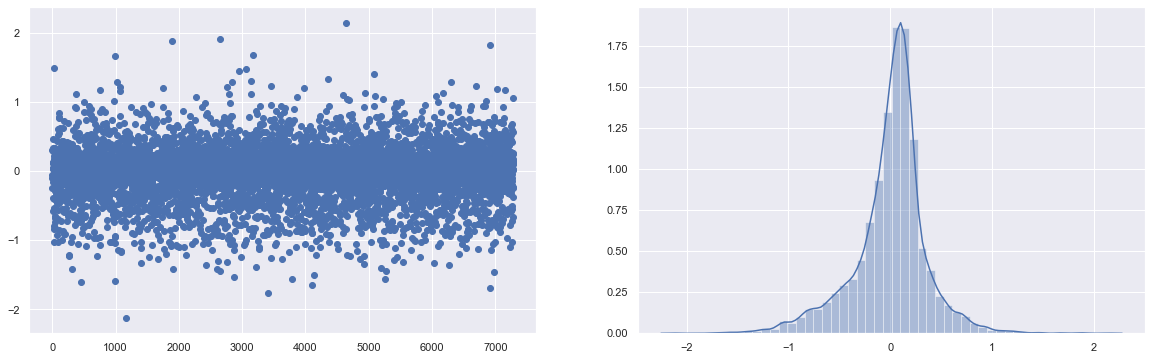

In [14]:
sns.set(rc={'figure.figsize':(10*2, 6)})
_ = plt.figure()

plt.subplot(1, 2, 1)

testing_resid = df_testing_Y - model.predict(df_testing_X)
_ = plt.scatter(x=range(0, len(testing_resid)), y=testing_resid)
#_ = plt.ylim(-1000, 1000)

plt.subplot(1, 2, 2)

_ = sns.distplot(testing_resid)

### Kolmogorov Smirnov test for Normality Assumption on Residuals

In [15]:
print('95% of residual values are from {} to {}\nwhich is approximately 6 units of sigma away from mu = 0'.format(model.resid.quantile(0.025), model.resid.quantile(0.0975)))

95% of residual values are from -0.8733743296080991 to -0.4733297621976975
which is approximately 6 units of sigma away from mu = 0


In [16]:
data = model.resid.sort_values()
n_sigmas = 100
proposed_sigma = np.linspace(float(abs(model.resid.quantile(0.025)) + abs(model.resid.quantile(0.0975)))/6, np.std(data), n_sigmas)
proposed_mu = 0
p_vals = np.zeros(n_sigmas)

for s in range(1, n_sigmas):
    empirical_cdf_data = np.linspace(1, len(data), len(data))

    empirical_cdf_data_b4_jump = empirical_cdf_data - 1

    empirical_cdf_data = empirical_cdf_data / len(data)

    empirical_cdf_data_b4_jump = empirical_cdf_data_b4_jump / len(data)

    theoratical_cdf_data = scipy.stats.norm.cdf(data, loc=proposed_mu, scale=proposed_sigma[s])

    # Supremum of the difference between theoratical cdf vs empirical cdf of data
    dN = max(max(abs(theoratical_cdf_data - empirical_cdf_data_b4_jump)), max(abs(empirical_cdf_data - theoratical_cdf_data)))

    # Generate K-S statistics for DN
    N = 1000
    n = 100
    DNS = np.zeros(N)
    for i in range(1, N):
        uniform_data = np.sort(np.random.rand(n))
        empirical_cdf_uniform = np.linspace(1, n, n)
        empirical_cdf_uniform_b4_jump = empirical_cdf_uniform - 1
        empirical_cdf_uniform = empirical_cdf_uniform / n
        empirical_cdf_uniform_b4_jump = empirical_cdf_uniform_b4_jump / n
        theoratical_cdf_uniform = scipy.stats.uniform.cdf(uniform_data)
        DNS[i] = max(max(abs(theoratical_cdf_uniform - empirical_cdf_uniform_b4_jump)), max(abs(empirical_cdf_uniform - theoratical_cdf_uniform)))

    DNS = np.sort(DNS)
    p_vals[s] = np.mean(DNS >= dN)

#print('p-value for K-S test is: ', np.mean(DNS >= DN) & (DN <= DNS)) / N)

In [17]:
test_result = pd.DataFrame({'proposed_sigma': proposed_sigma, 'p_value': p_vals}, columns=['proposed_sigma', 'p_value'])
test_result = test_result[test_result.p_value > 0.9]
print('Proposal sigma with p-value greater than 0.9 is \nfrom', test_result.proposed_sigma.min(), '\nto', test_result.proposed_sigma.max())
test_result.head(10)

Proposal sigma with p-value greater than 0.9 is 
from nan 
to nan


,proposed_sigma,p_value


After several trials with different proposal $\sigma$ values. The p-value for $\sigma$ is extremely high (more than 90%) with $ 0.3 < \sigma < 0.4 $, which is significantly to show that the residuals actually come from $\mathcal{N}(0, \sigma)$ where $\sigma$ is very likely from 0.3 to 0.4 

# Random Forest

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import GridSearchCV

def time_format(data):
    '''
    Function to convert dataset time columns into pandas datetime and calculations for promise date,
    approval time and total time to deliver
    '''
    data.order_delivered_customer_date=pd.to_datetime(data.order_delivered_customer_date, errors='coerce',format='%Y-%m-%d %H:%M')
    data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp,errors='coerce',format='%Y-%m-%d %H:%M')
    data.order_approved_at = pd.to_datetime(data.order_approved_at, errors='coerce',format='%Y-%m-%d %H:%M')
    data.order_estimated_delivery_date = pd.to_datetime(data.order_estimated_delivery_date, errors='coerce',format='%Y-%m-%d')
    data.order_delivered_customer_date = pd.to_datetime(data.order_delivered_customer_date, errors='coerce',format='%Y-%m-%d %H:%M')
    df.order_delivered_carrier_date = pd.to_datetime(data.order_delivered_carrier_date, errors='coerce',format='%Y-%m-%d %H:%M')
    data['promise_date'] = data.order_estimated_delivery_date >= data.order_delivered_customer_date  # True if product delivered before or at estimated delivery date
    data['approval_time'] = data.order_approved_at - data.order_purchase_timestamp  # Time for buyer to approve sale
    #data['total_time_to_deliver'] = data.order_delivered_customer_date - data.order_purchase_timestamp  # total time from pruchase to delivery
    #data['actual_delivery_time'] = data.order_delivered_customer_date - data.order_delivered_carrier_date  # total time from pruchase to delivery
    data['actual_delivery_time'] = (data['order_delivered_customer_date'] - data['order_delivered_carrier_date']).dt.total_seconds()/ (60 * 60)
    data['total_delivery_time'] = (data['order_delivered_customer_date'] - data['order_purchase_timestamp']).dt.total_seconds()/ (60 * 60)
    data['shipping_limit_date'] = pd.to_datetime(data.shipping_limit_date, errors='coerce', format='%Y-%m-%d %H:%M')
    return data

df = pd.read_csv('../../data/processed/20th_May_olist.csv' , dtype={'seller_zip_code_prefix': str, 'customer_zip_code_prefix': str})
df = time_format(df)

df3 = df

def previous_review_score(row):
    time=row.order_purchase_timestamp
    sel_id=row.seller_id
    return df3[(df3.seller_id==sel_id)&(df3.order_purchase_timestamp<time)].review_score.mean()

df3['review2']=df3.apply(previous_review_score,axis=1)

df3['order_delivered_carrier_date']=pd.to_datetime(df3.order_delivered_carrier_date, format='%Y-%m-%d %H:%M')
df3.order_purchase_timestamp = pd.to_datetime(df3.order_purchase_timestamp, format='%%Y-%m-%d %H:%M')

calculate_time_difference_in_hour(df3, 'order_delivered_carrier_date', 'order_purchase_timestamp', 'actual_lag_time')

df3=df3[['zip_2_prefix','rdpc', 'connection_between_states',
       'connection_between_cities', 'actual_lag_time','seasons','distance','review2','total_delivery_time']]

df3['I_connection_between_cities_and_states']=df3.connection_between_states*df3.connection_between_cities

df3.seasons=df3.seasons.map({'dry':0, 'wet':1})
df3.dropna(inplace=True)



/Users/dylanho/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dylanho/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/dylanho/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.or

## Correlation Matrix

The correlation of the features is useful to know if we should exclude any features. Highly correlated independent features are undesiable as it creates redundant features. However highly correlation between independent and dependent variable is desirable. In our case distence and connection between states are highly correlated however we will leave these features in for now but may remove them later. There is a high correlation between connection between cities which is good.

In [32]:
feat=['rdpc', 'seasons',
       'connection_between_cities', 'actual_lag_time']

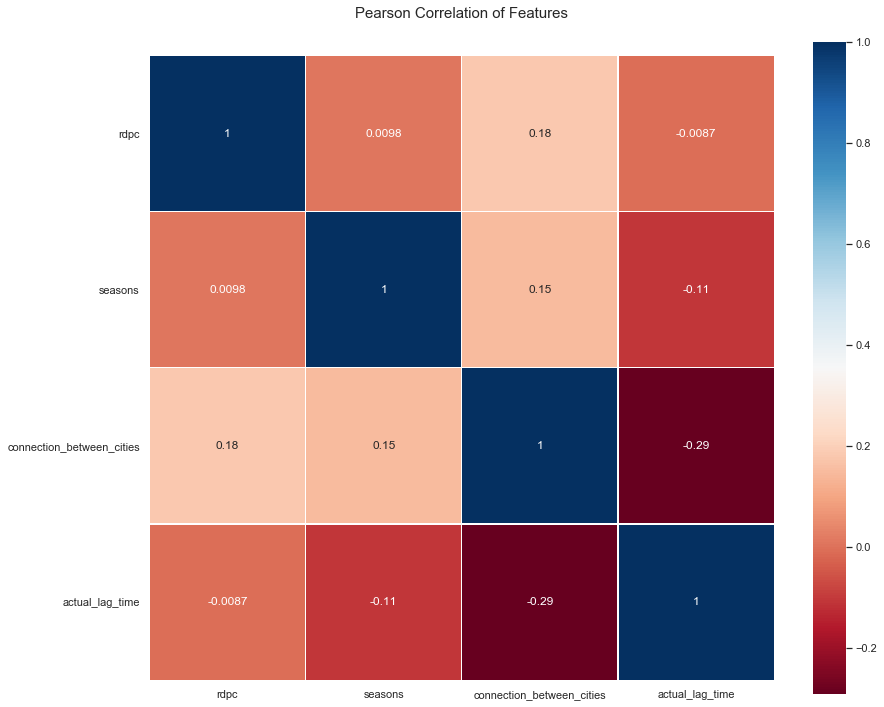

In [33]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df3[feat].corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.yticks(rotation = 0)
plt.show()

## Creating Datasets

In [34]:
def create_dataset(df,features):
    features=features
    target='total_delivery_time'
    x=df[features]
    y=np.log(df[target])
    if 'zip_2_prefix' in features:
        x=pd.get_dummies(data=x,columns=['zip_2_prefix'])
    return x,y

In [35]:
def build_random_forest(x,y,cv):
    #Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
    feature_name=x.columns
    clf = RandomForestRegressor(max_depth=4, random_state=0,n_jobs=-1)
    if cv==True:
        n_estimators = [100, 300]
        max_depth = [5, 8, ]
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [1, 2, 5] 

        hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
                      min_samples_split = min_samples_split, 
                     min_samples_leaf = min_samples_leaf)

        gridF = GridSearchCV(clf, hyperF, cv = 3, verbose = 1, 
                              n_jobs = -1)
        clf = gridF.fit(X_train, y_train)
        print(clf.best_params_)
        importance=pd.concat([pd.Series(feature_name),pd.Series(clf.best_estimator_.feature_importances_)],axis=1)
    else:
        clf.fit(X_train, y_train)
        importance=pd.concat([pd.Series(feature_name),pd.Series(clf.feature_importances_)],axis=1)
    
    pred=clf.predict(X_test)
    print('Test R2 Score:', r2_score(y_test,pred))
          
    pred2=clf.predict(X_train)
    print('Train R2 Score:', r2_score(y_train,pred2))
    
    
    
    importance.columns=['Features','Feature Importance Score']
    imp=importance[importance['Feature Importance Score']>0].set_index('Features')
    imp=imp.sort_values(by='Feature Importance Score',ascending=False)
    print(imp)
    
    return clf

In [36]:
features=['rdpc',
       'connection_between_cities', 'actual_lag_time','seasons']

**Without cv**

In [37]:
x,y=create_dataset(df3,features)
clf=build_random_forest(x,y,False)

Test R2 Score: 0.760947070489777
Train R2 Score: 0.7540907951351634
                           Feature Importance Score
Features                                           
connection_between_cities                  0.926721
actual_lag_time                            0.072908
rdpc                                       0.000334
seasons                                    0.000036


**With cv**

In [38]:
x_2,y_2=create_dataset(df3,features)
clf2=build_random_forest(x_2,y_2,True)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   32.2s finished


{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
Test R2 Score: 0.7867106059197464
Train R2 Score: 0.8131128044439025
                           Feature Importance Score
Features                                           
connection_between_cities                  0.870851
actual_lag_time                            0.103750
rdpc                                       0.022350
seasons                                    0.003049


In [39]:
clf2.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}